# Importo librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
plt.rcParams.update({
    'axes.titlesize': 20,      # Tamaño título
    'axes.labelsize': 18,      # Tamaño etiquetas ejes
    'xtick.labelsize': 18,     # Tamaño etiquetas eje x
    'ytick.labelsize': 18,     # Tamaño etiquetas eje y
    'legend.fontsize': 18,     # Tamaño leyenda
    'figure.titlesize': 20     # Tamaño título figura (si usás)
})

# Funcion de ajuste cubico

In [3]:
def modelo_cubica(x, a, b, c, d):
    return a + b * x + c * x**2 + d * x**3

def ajuste_cubica(x, y, p0):
    # Ajuste
    popt, _ = curve_fit(modelo_cubica, x, y, p0=p0)
    a, b, c, d = popt

    # Valores ajustados y residuos
    y_ajustada = modelo_cubica(x, *popt)
    residuos = y - y_ajustada

    # Resultados por pantalla
    print("Ajuste y = a + b*x + c*x² + d*x³")
    print(f"a: {a:.5g}")
    print(f"b: {b:.5g}")
    print(f"c: {c:.5g}")
    print(f"d: {d:.5g}")

    # Preparar figura con dos subplots, compartiendo eje x
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True,
                                   gridspec_kw={'height_ratios': [5, 3]})

    # Ajuste y datos
    ax1.errorbar(x, y, fmt='o', label='Datos medidos')
    x_fit = np.linspace(min(x), max(x), 300)
    y_fit = modelo_cubica(x_fit, *popt)
    ax1.plot(x_fit, y_fit, 'r-', label=r'$P(x) = a + b x + c x^2 + d x^3$')

    ax1.set_ylabel(r"$Distancia$ $[mm]$", fontsize=18)
    ax1.grid(True)
    ax1.legend(fontsize=16)

    # Texto fijo con valores definidos y formato correcto
    textstr = '\n'.join((
        r'$a = {a:.5g}$'.format(a=a),
        r'$b = {b:.5g}$'.format(b=b),
        r'$c = {c:.5g}$'.format(c=c),
        r'$d = {d:.5g}$'.format(d=d)
    ))

    ax1.text(0.02, 0.03, textstr, transform=ax1.transAxes, fontsize=14,
             verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='#ddaaff', alpha=0.8))

    # Residuos
    ax2.axhline(0, color='k', linestyle='--', linewidth=1)
    ax2.errorbar(x, residuos, fmt='o', label='Residuos')
    ax2.set_xlabel(r"$B_{iman}$ $[u.a]$", fontsize=18)
    ax2.set_ylabel(r"$Residuos$ $[mm]$", fontsize=18)
    ax2.grid(True)
    ax2.legend(fontsize=16)

    plt.tight_layout()
    plt.show()

    return a, b, c, d

# Leo y ajusto los datos de distancia en funcion del campo del iman

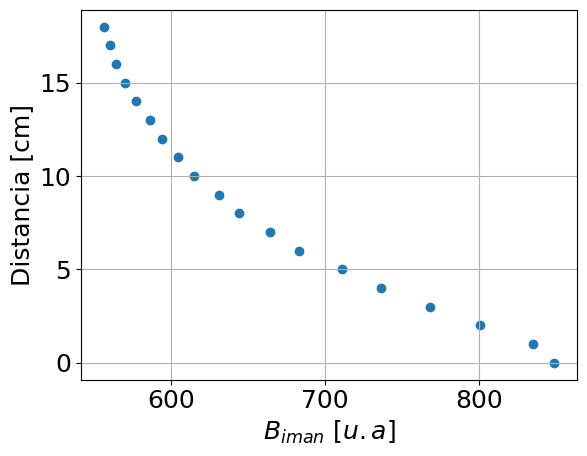

In [4]:
ruta = "/content/drive/MyDrive/Calibraciones/Ejemplo_B_IMAN.xlsx"

df = pd.read_excel(ruta, header=None)

altura = df.iloc[:, 0].to_numpy()
B_iman = df.iloc[:, 1].to_numpy()

# Divido por 20 porque tome 20 mediciones en la calibracion
plt.scatter(B_iman/20, altura)
plt.xlabel(r"$B_{iman}$ $[u.a]$")
plt.ylabel('Distancia [cm]')
plt.grid(True)
plt.show()

In [5]:
# PArametros estimados iniciales
p0 = [0, 0, 0, 0.001]
# Ajusto
a, b, c, d = ajuste_cubica(x=B_iman/20, y=altura, p0=p0)

Ajuste y = a + b*x + c*x² + d*x³
a: 521.87
b: -2.0213
c: 0.0026615
d: -1.1834e-06


# Grafico la curva de los PWM, asi luego armo la tabla

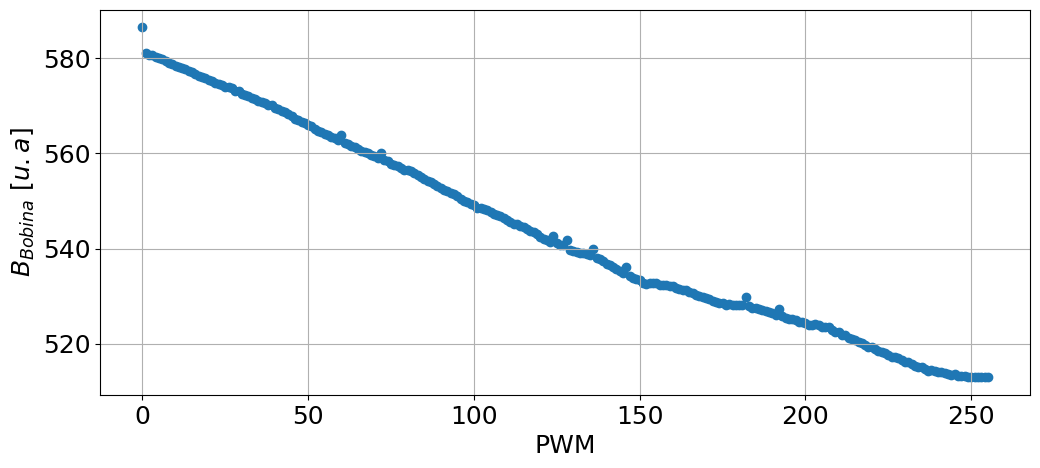

In [6]:
ruta = "/content/drive/MyDrive/Calibraciones/Ejemplo_PWM.xlsx"

df = pd.read_excel(ruta, header=None)

# Extraemos las columnas como arrays de numpy
pwm = df.iloc[:, 0].to_numpy()
campo_bobina = df.iloc[:, 1].to_numpy()
plt.figure(figsize=(12, 5))
plt.scatter(pwm, campo_bobina/20)
plt.xlabel('PWM')
plt.ylabel(r'$B_{Bobina}$ $[u.a]$')
plt.grid(True)
plt.show()



Se quiere que quede alineado el valor de pwm con el indice del array que se va a usar para arduino. Entonces ordeno por pwm de menor a mayor los datos del campo pwm. Luego esta tabla la puedo copiar en arduino.

In [7]:
# Ordeno por PWM ascendente
orden = np.argsort(pwm)
pwm_ordenado = pwm[orden]
campo_ordenado = campo_bobina[orden] / 20

# Imprimo en formato de array C para Arduino
print("const float tabla_campo[256] = {")
for i, val in enumerate(campo_ordenado):
    end_char = ",\n" if (i + 1) % 8 == 0 else ", "
    if i == 255:
        end_char = "\n};"
    print(f"  {val:.4f}{end_char}", end="")

const float tabla_campo[256] = {
  586.5000,   581.1000,   580.7500,   580.6000,   580.2500,   579.9500,   579.8500,   579.4000,
  579.0000,   578.8500,   578.4000,   578.0500,   577.9000,   577.6500,   577.4000,   577.0000,
  576.6000,   576.3500,   576.0000,   575.8000,   575.5000,   575.2500,   574.8500,   574.6000,
  574.3500,   573.9500,   573.8500,   573.6500,   573.0500,   573.0000,   572.4500,   572.3500,
  572.0500,   571.6000,   571.5000,   571.0500,   570.8500,   570.6000,   570.2500,   570.1000,
  569.5500,   569.2500,   568.8000,   568.6500,   568.3500,   567.8500,   567.2000,   567.0000,
  566.5500,   566.3000,   565.9000,   565.7000,   565.1500,   564.6500,   564.4500,   564.0000,
  563.8500,   563.5000,   563.2000,   562.8000,   563.9000,   562.1000,   561.9000,   561.5000,
  561.2500,   561.0000,   560.5500,   560.2500,   560.0000,   559.6000,   559.4500,   559.0500,
  560.1000,   558.5000,   558.3000,   557.8500,   557.6000,   557.2500,   556.8500,   556.6000,
  556.4